In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 50)

# orders_qu.csv
url = "https://drive.google.com/file/d/143CzG5DriVSPMkaL1UP4k3Y80oS8fgbV/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_qu = pd.read_csv(path)

# orderlines_qu.csv
url = "https://drive.google.com/file/d/1yWO-mQfxQtnSZdCgdNlIEUrZSCW1HN5O/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_qu = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

# backup
# products_df = products.copy()
# orders_df = orders.copy()
# orderlines_df = orderlines.copy()
# brands_df = brands.copy()

# products https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=drive_link
# orders https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=drive_link
# orderlines https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=drive_link
# brands https://drive.google.com/file/d/1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD/view?usp=drive_link

# orders_qu https://drive.google.com/file/d/16MehTZmz2eI0tUYgtNKXg1aJzjU-RNvo/view?usp=sharing
# orderlines_qu https://drive.google.com/file/d/1JGS6vrvo6tLNj7oQMOikcrU_WlHFnlNj/view?usp=sharing
# products_cl https://drive.google.com/file/d/15q4B4Mgl7zSRRNSHgt0fo7Hn2GDUNx_h/view?usp=sharing
# brands_cl https://drive.google.com/file/d/1pAjJqtC_rrYTZ79bemuffh__KNOXhOyl/view?usp=sharing

- What is the time period that the dataset covers?
- What is the overall revenue for that time?
- Are there seasonal patterns in the evolution of sales?
- What are the most sold products?
- What are the products that generate the most revenue?

In [2]:
# data preparation
orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])
orderlines_qu['date'] = pd.to_datetime(orderlines_qu['date'])
orderlines_qu.loc[:,'unit_price_total'] = orderlines_qu['unit_price'] * orderlines_qu['product_quantity']

## Category

In [3]:
products_category_df = products_cl.copy()

New dataframe 'final_df'

key: type

In [4]:
# Convert columns to lowercase
products_category_df['name_lower'] = products_category_df['name'].str.lower()
products_category_df['desc_lower'] = products_category_df['desc'].str.lower()

# Remove whitespace before " and add a single space after "
products_category_df['name_lower'] = products_category_df['name_lower'].str.replace(r'\s+"', '" ', regex=True)
products_category_df['desc_lower'] = products_category_df['desc_lower'].str.replace(r'\s+"', '" ', regex=True)

# Combine words from 'name' and 'desc' columns into one column, split and explode
combined_words = products_category_df.assign(
    words=products_category_df['name_lower'].str.split() + products_category_df['desc_lower'].str.split()
).explode('words')

# Filter out unwanted standalone symbols (/, |, -, +) using regex
combined_words = combined_words[~combined_words['words'].str.match(r'^[\|\-/+]$')]

# Group by 'type' and 'words' to count word occurrences
word_counts = (
    combined_words
    .groupby(['type', 'words'])
    .size()
    .reset_index(name='count')
    .sort_values(['type', 'count'], ascending=[True, False])
)

# Get the top 8 words for each 'type'
top_words = (
    word_counts
    .groupby('type')
    .apply(lambda x: x.nlargest(8, 'count'))
    .reset_index(drop=True)
)

# Aggregate results to get the final DataFrame
final_df = (
    top_words
    .groupby('type')
    .agg(
        count=('count', 'sum'),  # Sum of counts of top 3 words
        top8_words=('words', lambda x: ', '.join(x))  # Comma-separated top 3 words
    )
    .reset_index()
)
final_df.head(3)


/var/folders/vs/m818tpl12dx9lgmg3w2kzqch0000gn/T/ipykernel_708/102074868.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(8, 'count'))


,type,count,top8_words
0,"1,02E+12",1768,"pro, macbook, ssd, core, bar, touch, 16gb, i7"
1,"1,44E+11",1152,"repair, iphone, and, parts, labor, for, servic..."
2,10142,178,"battery, macbook, pro, newertech, nupower, lat..."


In [5]:
# Grouping the products_category_df table by type
type_price_info = (
    products_category_df
    .groupby('type')
    .agg(
        sku_count=('sku', 'count'),
        price_avg=('price', 'mean'),
        price_median=('price', 'median'),
        price_min=('price', 'min'),
        price_max=('price', 'max')
    )
    .reset_index()
)

# Merging tables with prices and the top 8 words
type_price_top8 = type_price_info.merge(final_df, how='left', on='type')

# Joining products with order lines by SKU
product_orders_info = products_category_df.merge(orderlines_qu.loc[:,['sku','unit_price_total','product_quantity','id_order']], how='left', on='sku')

# Grouping by type to calculate the aggregated sum of unit prices
type_orders_info = product_orders_info.groupby('type').agg(unit_price_total=('unit_price_total', 'sum'), unique_orders=('id_order', 'nunique'), product_quantity=('product_quantity','sum')).reset_index()
type_orders_info = type_orders_info.sort_values('unit_price_total', ascending=False)

# Final table with information about types
type_info = type_price_top8.merge(type_orders_info, how='left', on='type')
type_info_df = type_info.copy()


Now we can manually assign a category for most types.

example:
```
{
'5,74E+15':'imac',
'1,02E+12':'macbook',
'1282':'imac',
'11935397':'hard drive',
...
}
```

In [6]:
type_info.sort_values('unit_price_total', ascending=False).head(5)

,type,sku_count,price_avg,price_median,price_min,price_max,count,top8_words,unit_price_total,unique_orders,product_quantity
17,11935397,562,751.52,211.49,8.99,10212.99,4316,"and, hard, drive, usb, mac, 3.0, for, external",738576.55,3669,4324.00
40,1296,187,512.68,399.00,104.99,2328.04,1188,"monitor, and, for, mac, hdmi, pc, with, ips",656947.12,1471,1722.00
23,12175397,939,1203.41,1006.95,91.99,5894.49,6944,"nas, and, server, ram, mac, synology, for, sea...",460434.85,1085,1114.00
24,12215397,170,404.09,279.00,49.90,2660.99,1144,"ssd, and, macbook, for, pro, mac, kit, owc",451277.53,1927,2322.00
49,1364,216,179.99,99.99,10.99,1383.96,1483,"mac, memory, ram, so-dimm, ddr3, pro, imac, owc",387748.96,3030,3822.00


In [7]:
type_dict = {
    '5,74E+15':'Apple iMac 27',
    '1,02E+12':'Apple Macbook Pro 13/15',
    '1282':'Apple iMac',
    '11935397':'Hard drive',
    '1296':'Monitor',
    '12175397':'NAS Server / Network',
    '2,17E+11':'(Open) Apple Macbook Pro 13/ 15',
    '12215397':'SSD',
    '1405':'graphic tablet',
    '2,16E+11':'Apple iMac 21.5',
    '1364':'mac RAM',
    '12655397':'Mac PC Hard Drive',
    '2158':'Apple MacBook Pro',
    '51601716':'(Open) Apple iPhone',
    '11905404':'bluetooth device',
    '113281716':'Apple iPhone 8 Plus',
    '5384':'Headphones',
    '113291716':'Apple iPhone 8',
    '85641716':'Apple iPhone 7',
    '85651716':'Apple iPhone 7 Plus',
    '106431714':'Apple iPad 64gb',
    '1433':'SSD',
    '24895185':'Apple Watch',
    '1298':'Open',
    '5398':'speaker',
    '1714':'iPad',
    '113271716':'Apple iPhone X',
    '21561716':'Apple iPhone 6',
    '12585395':'Adapter',
    '11865403':'iPhone case',
    '1231':'Service',
    '21632158':'mac',
    '5,39E+11':'macbook',
    '12995397':'thunderbolt',
    '10142':'battery',
    '13855401':'keyboard',
    '51861714':'iPad pro 256gb',
    '24821716':'iphone 6s',
    '118692158':'imac',
    '13005399':'macbook charger',
    '24885185':'apple watch',
    '1229':'pointer',
    '42945397':'lightning usb',
    '12635403':'iPad case',
    '51871714':'ipad',
    '1334':'router',
    '57445397':'memory card',
    '1325':'cable',
    '1387':'mouse',
    '13835403':'macbook case',
    '2449':'Apple Watch strap'
}
products_category_df['category'] = products_category_df['type'].map(type_dict)
products_category_df.loc[products_category_df['category'].isna(),'category'] = 'other'

In [8]:
products_category_df.groupby('category').size().sort_values(ascending=False)

category
other                              1711
iPhone case                        1057
NAS Server / Network                939
Open                                783
Hard drive                          562
bluetooth device                    454
Apple iMac                          373
iPad case                           362
SSD                                 341
macbook case                        269
Apple iMac 27                       247
mac RAM                             216
Adapter                             190
Monitor                             187
cable                               183
Headphones                          178
speaker                             159
Apple Macbook Pro 13/15             130
memory card                         129
router                              115
Apple MacBook Pro                   107
Apple Watch strap                   107
Mac PC Hard Drive                   105
pointer                             104
thunderbolt                    

In [9]:
products_category_df.loc[products_category_df['type'] == '51601716'].sort_values('price', ascending=True).sample(5)

,sku,name,desc,price,in_stock,type,name_lower,desc_lower,category
7982,AP20267,Like New - iPhone 5s 16GB Space Gray,Apple iPhone 5s 16GB Free refitted in Gray Space,409.00,0,51601716,like new - iphone 5s 16gb space gray,apple iphone 5s 16gb free refitted in gray space,(Open) Apple iPhone
8717,AP20057,Like new - Apple iPhone 5s 16GB Space Gray,iPhone 5S 16GB state as new and completely rev...,409.00,0,51601716,like new - apple iphone 5s 16gb space gray,iphone 5s 16gb state as new and completely rev...,(Open) Apple iPhone
3869,APP1481,Apple iPhone 64GB Space Gray,New iPhone SE with 4-inch screen 64 free GB.,549.00,0,51601716,apple iphone 64gb space gray,new iphone se with 4-inch screen 64 free gb.,(Open) Apple iPhone
7924,AP20258,Like new - Apple iPhone 16GB Silver,Apple iPhone SE Free Refurbished 16GB Color Si...,489.00,0,51601716,like new - apple iphone 16gb silver,apple iphone se free refurbished 16gb color si...,(Open) Apple iPhone
6729,APP1968,Apple iPhone 32GB Gold,New iPhone SE with 4-inch screen 32 free GB.,419.00,0,51601716,apple iphone 32gb gold,new iphone se with 4-inch screen 32 free gb.,(Open) Apple iPhone


In [10]:
orderlines_info = orderlines_qu.merge(products_category_df.loc[:,['sku','name', 'desc', 'price', 'type', 'category']], how='left', on='sku')
orderlines_info.loc[:,'price_total'] = orderlines_info['price'] * orderlines_info['product_quantity']
orderlines_info.loc[:,'discount'] = orderlines_info['price'] - orderlines_info['unit_price']
orderlines_info.head(3)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,name,desc,price,type,category,price_total,discount
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,12755395,other,60.99,13.50
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,5720,other,22.95,3.96
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,89.00,13005399,macbook charger,89.00,16.81


In [11]:
orderlines_info.loc[:,"weekday"] = orderlines_info["date"].dt.weekday
orderlines_info.loc[:,"day_of_week"] = orderlines_info["date"].dt.day_name()
orderlines_info.loc[:,"day"] = orderlines_info["date"].dt.day
orderlines_info.loc[:,"month"] = orderlines_info["date"].dt.month
orderlines_info.loc[:,"year"] = orderlines_info["date"].dt.year
orderlines_info.loc[:,"week_date"] = orderlines_info["date"].dt.to_period('W').dt.start_time.dt.date
orderlines_info.loc[:,"month_date"] = orderlines_info["date"].dt.to_period('M').dt.start_time.dt.date

In [12]:
category_mapping = {
    '5,74E+15': 'Apple iMac',
    '1,02E+12': 'Apple Macbook',
    '1282': 'Apple iMac',
    '11935397': 'Memory Storage',
    '1296': 'Monitor',
    '12175397': 'Network',
    '2,17E+11': 'Apple Macbook',
    '12215397': 'Memory Storage',
    '1405': 'Graphics Tablet',
    '2,16E+11': 'Apple iMac',
    '1364': 'Memory Storage',
    '12655397': 'Memory Storage',
    '2158': 'Apple Macbook Pro',
    '51601716': 'Second hand',
    '11905404': 'Accessories',
    '113281716': 'Apple iPhone',
    '5384': 'Headphones',
    '113291716': 'Apple iPhone',
    '85641716': 'Apple iPhone',
    '85651716': 'Apple iPhone',
    '106431714': 'Apple iPad',
    '1433': 'Memory Storage',
    '24895185': 'Apple Watch',
    '1298': 'Second hand',
    '5398': 'Speakers',
    '1714': 'Apple iPad',
    '113271716': 'Apple iPhone',
    '21561716': 'Apple iPhone',
    '12585395': 'Accessories',
    '11865403': 'Accessories',
    '1231': 'Service',
    '21632158': 'Apple Macbook',
    '5,39E+11': 'Apple Macbook',
    '12995397': 'Accessories',
    '10142': 'Accessories',
    '13855401': 'Accessories',
    '51861714': 'Apple iPad',
    '24821716': 'Apple iPhone',
    '118692158': 'Apple iMac',
    '13005399': 'Accessories',
    '24885185': 'Apple Watch',
    '1229': 'Accessories',
    '42945397': 'Accessories',
    '12635403': 'Accessories',
    '51871714': 'Apple iPad',
    '1334': 'Network',
    '57445397': 'Memory Storage',
    '1325': 'Accessories',
    '1387': 'Accessories',
    '13835403': 'Accessories',
    '2449': 'Accessories'
}
   
# Apply the mapping to create the new 'category_level' column
orderlines_info.loc[:,'category_level'] = orderlines_info['type'].map(category_mapping)

# Fill missing values with 'Other'
orderlines_info.loc[:,'category_level'] = orderlines_info['category_level'].fillna('Other')


In [13]:
orderlines_info.loc[:,['sku','category','category_level']]

,sku,category,category_level
0,OWC0100,other,Other
1,IOT0014,other,Other
2,APP0700,macbook charger,Accessories
3,CRU0039-A,Open,Second hand
4,PEB0015,bluetooth device,Accessories
...,...,...,...
53226,APP0698,other,Other
53227,APP0698,other,Other
53228,APP0698,other,Other
53229,APP0698,other,Other


<Axes: xlabel='month_date', ylabel='unit_price_total'>

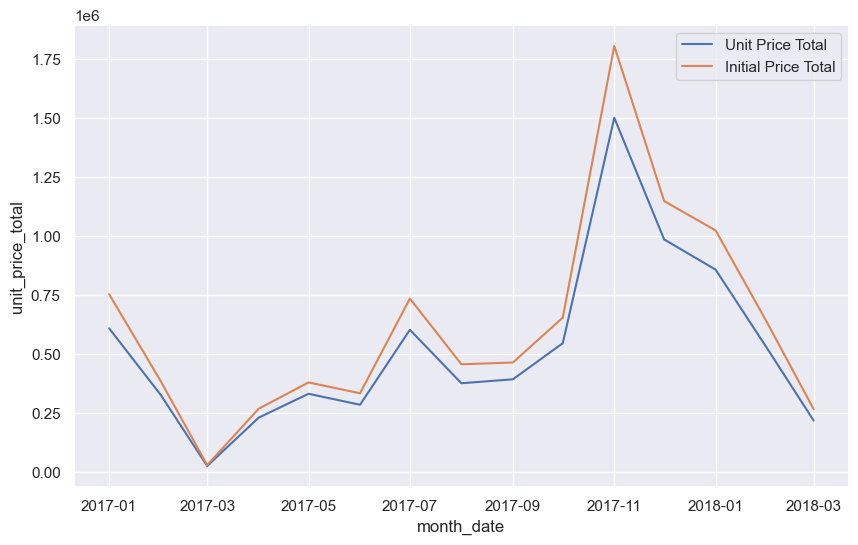

In [14]:
# Group data by month and calculate the sum of unit_price_total and price_total
monthly_sales = orderlines_info.groupby('month_date').agg(
    {'unit_price_total': 'sum', 'price_total': 'sum'}
).reset_index()
sns.set(rc={"figure.figsize":(10, 6)})
# Create the line plot
# plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales,
             x='month_date',
             y='unit_price_total',
             label='Unit Price Total')
sns.lineplot(data=monthly_sales,
             x='month_date',
             y='price_total',
             label='Initial Price Total')

In [15]:
monthly_discount_by_category = orderlines_info.groupby(['week_date', 'category_level']).agg({'discount': 'sum',
                                                                                             'price_total': 'sum',
                                                                                             'product_quantity': 'sum'}).reset_index()
monthly_discount_by_category['discount_level'] = monthly_discount_by_category['discount'] / monthly_discount_by_category['price_total']
monthly_discount_by_category.head(3)

,week_date,category_level,discount,price_total,product_quantity,discount_level
0,2016-12-26,Accessories,1116.18,3756.76,42,0.30
1,2016-12-26,Apple iPhone,-260.00,2277.00,3,-0.11
2,2016-12-26,Graphics Tablet,374.70,1679.96,4,0.22


<Axes: xlabel='week_date', ylabel='discount_level'>

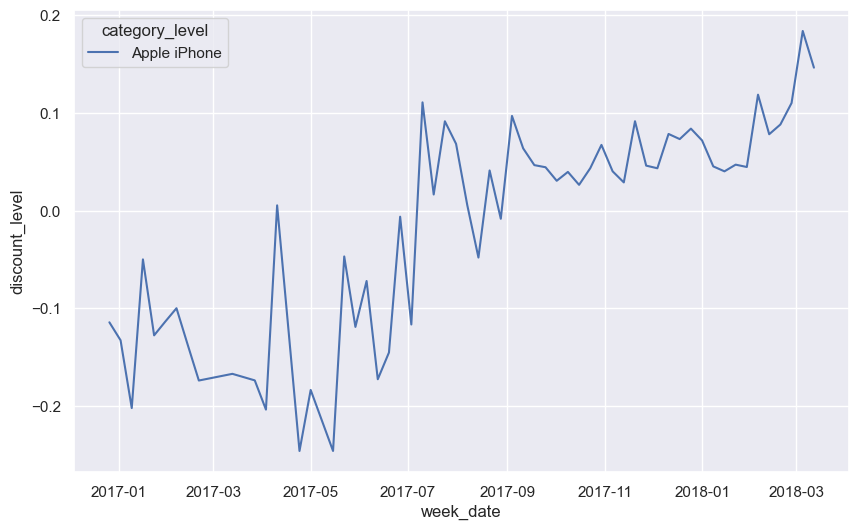

In [16]:
sns.lineplot(data=monthly_discount_by_category.loc[monthly_discount_by_category.loc[:,'category_level'] =='Apple iPhone'],
             x='week_date',
             y='discount_level',
             hue='category_level')

<Axes: xlabel='week_date', ylabel='product_quantity'>

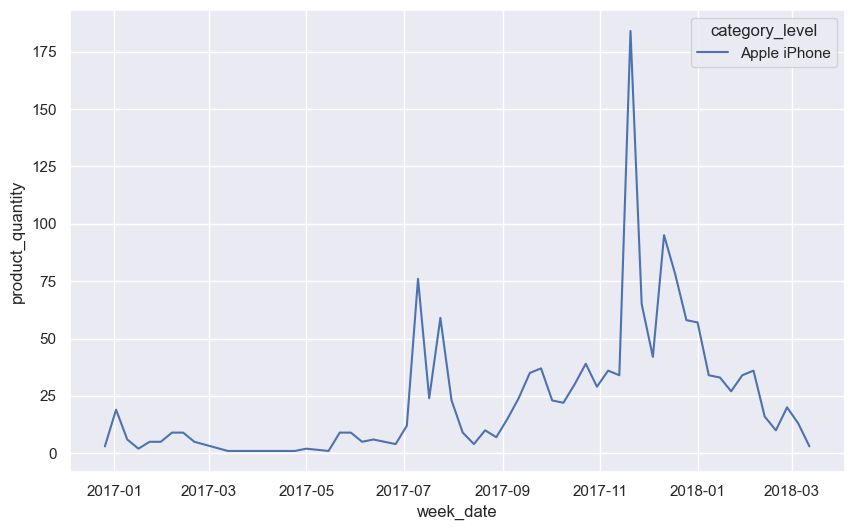

In [17]:
sns.lineplot(data=monthly_discount_by_category.loc[monthly_discount_by_category.loc[:,'category_level'] =='Apple iPhone'],
             x='week_date',
             y='product_quantity',
             hue='category_level')

# Payal
## To calculate reveneu and find total sale merge the orders table with orderline_info with category and other info.
### Steps: 
1. Merge orders with orderline_info
2. Group by category_level to find overall reveneu and total sale per qt.
3. find overall reveneu and total sale for second hand products per qt.
3. Group by category_level to find overall reveneu and total sale per month
4. find overall reveneu and total sale for second hand products per month.

In [18]:
# Step 1.  Merge orders with orderline_info
orders_info = (orders_qu.merge(orderlines_info,
                               how='left',
                               left_on = 'order_id',
                               right_on = 'id_order'))
orders_info.loc[:,'quarter'] = orders_info['date'].dt.quarter

orders_info['year_quarter'] = ''
year_quarter_mask=orders_info['year'] == 2018
orders_info.loc[year_quarter_mask, 'year_quarter'] = 5
year_quarter_mask2=orders_info['year'] == 2017
orders_info.loc[year_quarter_mask2, 'year_quarter'] = orders_info["quarter"]

orders_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53231 entries, 0 to 53230
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          53231 non-null  int64         
 1   created_date      53231 non-null  datetime64[ns]
 2   total_paid        53231 non-null  float64       
 3   state             53231 non-null  object        
 4   id                53231 non-null  int64         
 5   id_order          53231 non-null  int64         
 6   product_id        53231 non-null  int64         
 7   product_quantity  53231 non-null  int64         
 8   sku               53231 non-null  object        
 9   unit_price        53231 non-null  float64       
 10  date              53231 non-null  datetime64[ns]
 11  unit_price_total  53231 non-null  float64       
 12  name              53231 non-null  object        
 13  desc              53231 non-null  object        
 14  price             5323

In [19]:
# 2. Group by category_level to find overall reveneu and total sale per qt.

rev_sale_cat_qt = (orders_info.groupby(['category_level','year_quarter'])
                   .agg({'unit_price_total':'sum',#total reveneu
                         'discount':'sum',#total discount
                         'product_quantity':'sum'#total sale
                         })
                    ).reset_index()
rev_sale_cat_qt

,category_level,year_quarter,unit_price_total,discount,product_quantity
0,Accessories,1,161868.62,59884.67,3272
1,Accessories,2,121282.52,26090.18,2279
2,Accessories,3,176405.44,46361.72,3334
3,Accessories,4,360031.86,90704.71,5940
4,Accessories,5,252852.76,62284.72,4322
5,Apple Macbook,2,1738.00,460.00,2
6,Apple Macbook,3,12726.14,4008.86,15
7,Apple Macbook,4,47525.38,6628.76,49
8,Apple Macbook,5,34393.08,5244.57,36
9,Apple Watch,1,13596.13,253.87,30


In [20]:
# coloring plotting
# Define a consistent color palette based on the unique categories
unique_categories = orders_info['category_level'].unique()
palette = sns.color_palette("dark", len(unique_categories))
color_mapping = dict(zip(unique_categories, palette))

Text(0.5, 0.98, 'Categorical sale')

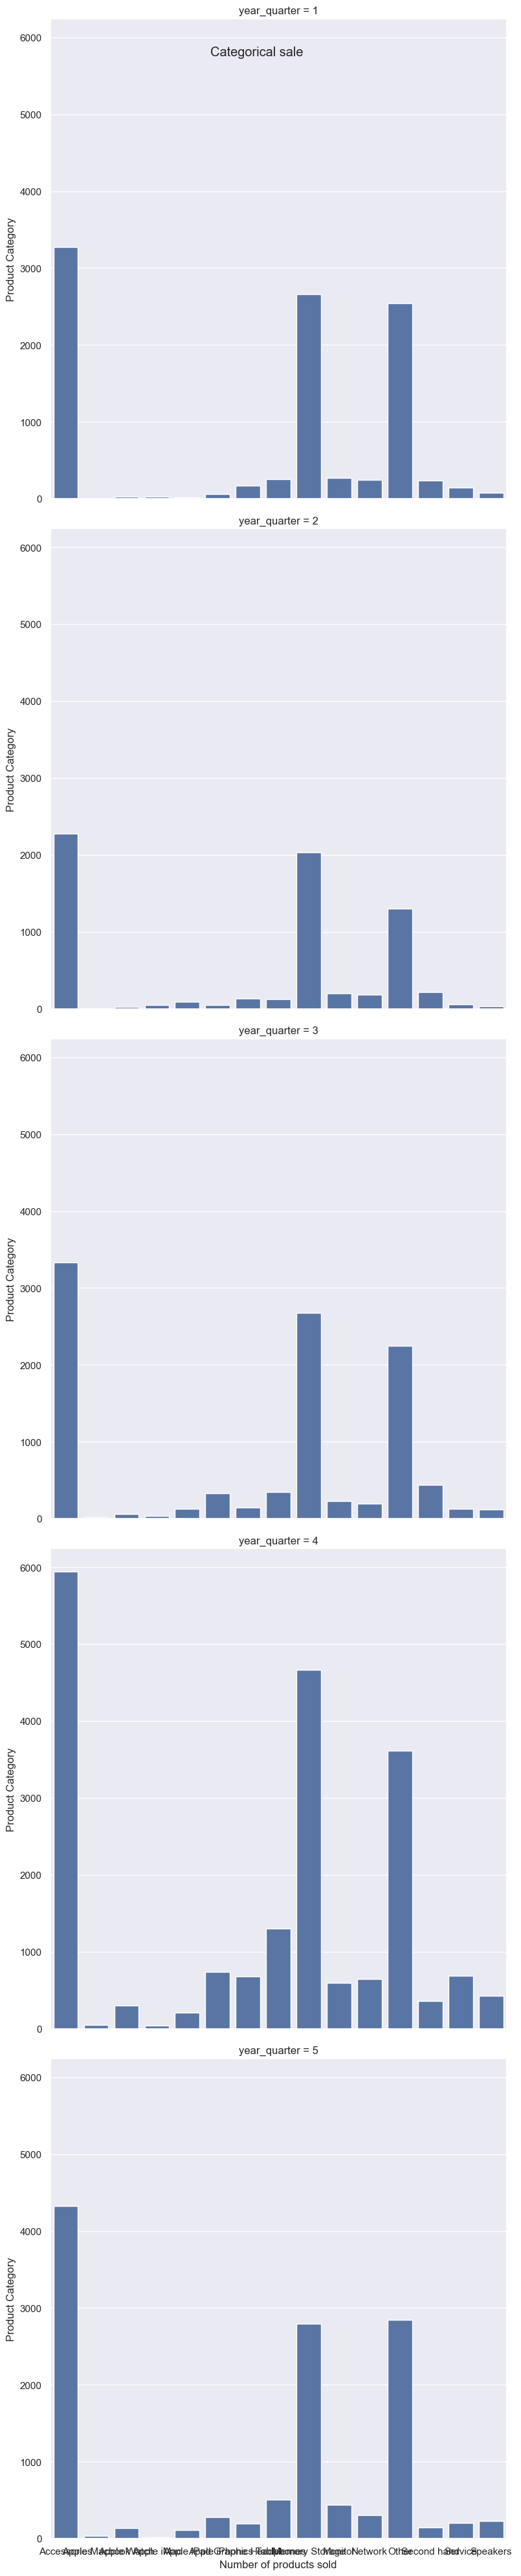

In [21]:
(
sns.catplot(data = rev_sale_cat_qt,
                 x="category_level",
                 y="product_quantity",
                 row="year_quarter",
                 kind="bar",
                 height=8)
    .set_axis_labels("Number of products sold",
                     "Product Category")
    .figure.suptitle("Categorical sale")
)

Text(0.5, 0.98, 'Categorical sale per quarter')

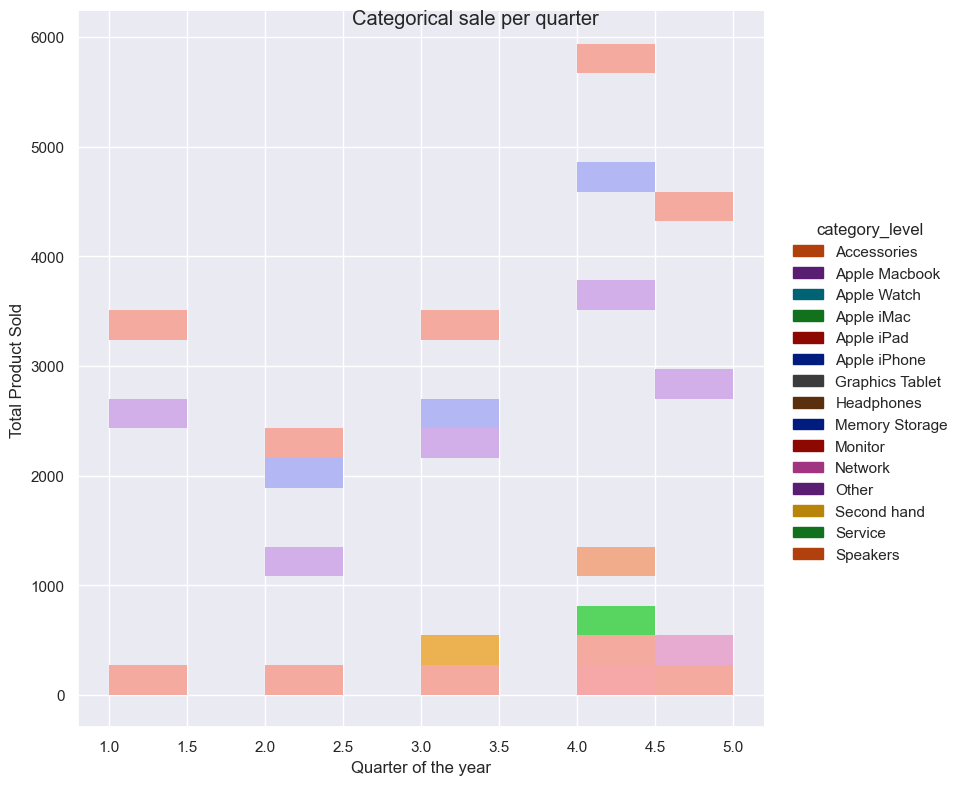

In [22]:
# to plot sale
(
sns.displot(data = rev_sale_cat_qt,
                 hue ="category_level",
                 y="product_quantity",
                 x="year_quarter",
                 stat = 'percent',
                 palette = color_mapping,
                 height=8)
    .set_axis_labels("Quarter of the year",
                     "Total Product Sold")
    .figure.suptitle("Categorical sale per quarter")
)

Text(0.5, 0.98, 'Categorical reveneu per quarter')

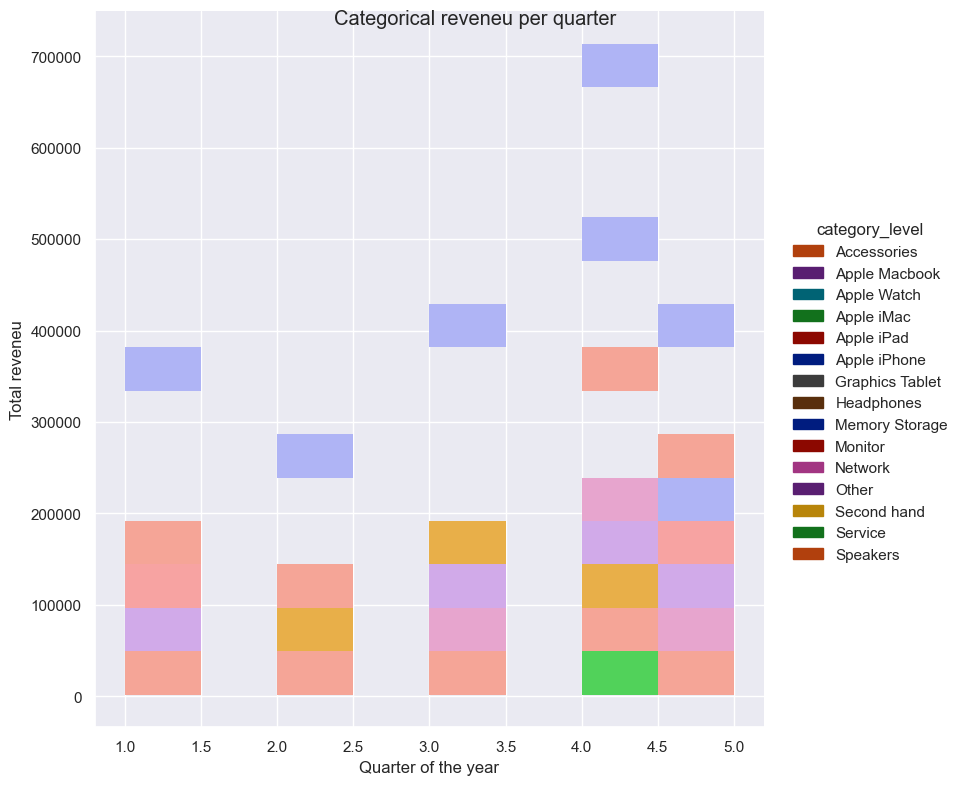

In [23]:
# to plot reveneu
(
sns.displot(data = rev_sale_cat_qt,
                 hue ="category_level",
                 y="unit_price_total",
                 x="year_quarter",
                 stat = 'percent',
                 palette = color_mapping,
                 height=8)
    .set_axis_labels("Quarter of the year",
                     "Total reveneu")
    .figure.suptitle("Categorical reveneu per quarter")
)

Text(0.5, 0.98, 'Categorical reveneu with respect to sales')

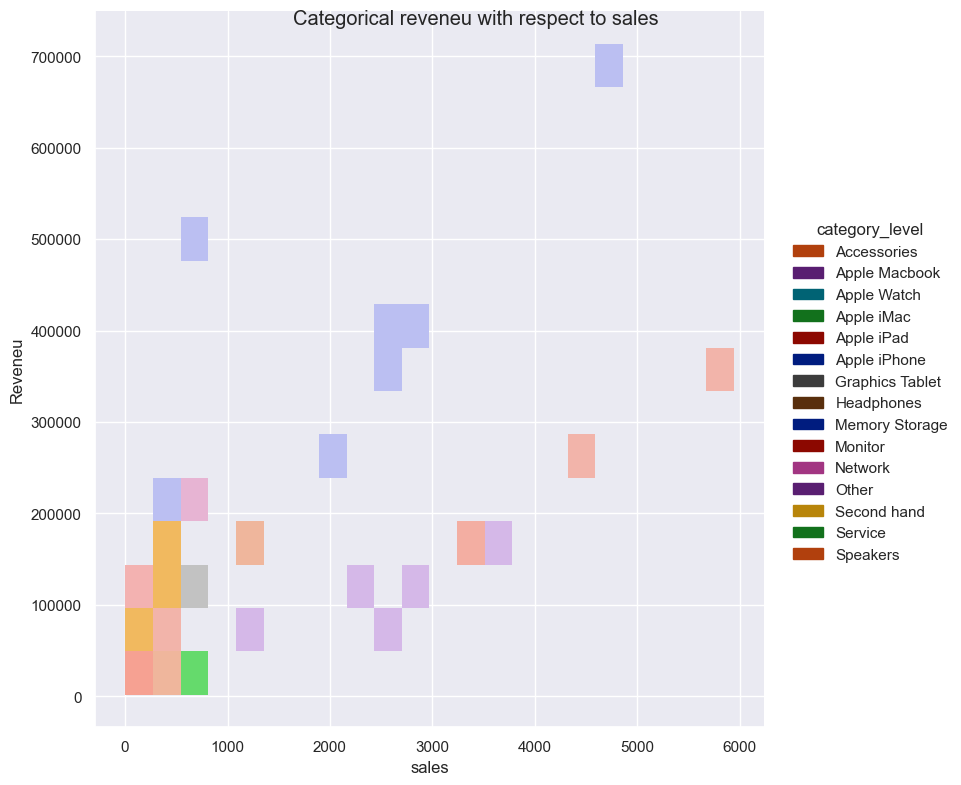

In [24]:
# to plot reveneu vs sale 
(
sns.displot(data = rev_sale_cat_qt,
                 hue ="category_level",
                 y="unit_price_total",
                 x="product_quantity",
                 palette = color_mapping,
                 height=8)
                .set_axis_labels("sales",
                     "Reveneu")
    .figure.suptitle("Categorical reveneu with respect to sales")
)

Text(0.5, 0.98, 'Quarterly Categorical reveneu')

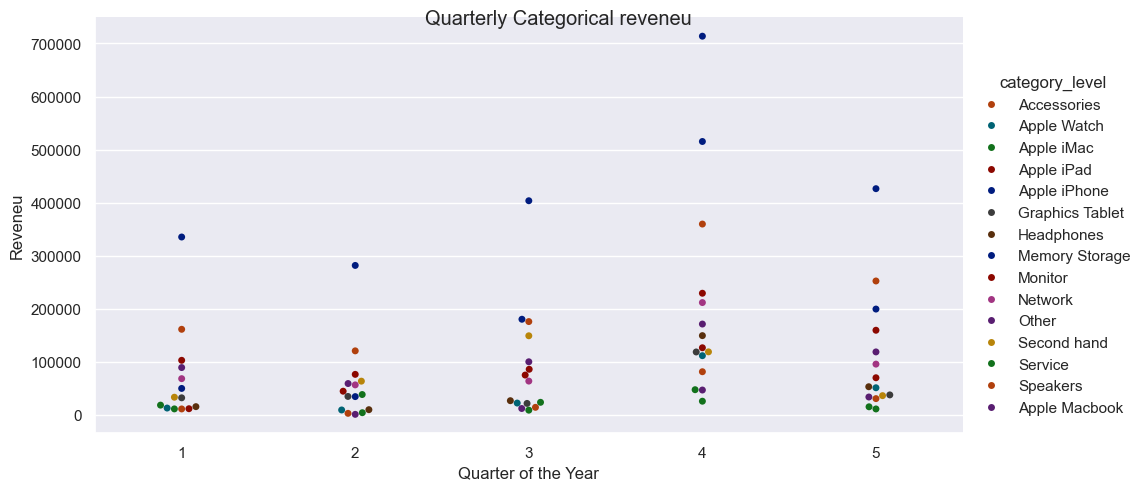

In [25]:
(sns.catplot(
    data=rev_sale_cat_qt, x="year_quarter", y="unit_price_total", hue="category_level",
    kind="swarm", palette= color_mapping,aspect=2
).set_axis_labels("Quarter of the Year",
                  "Reveneu")
    .figure.suptitle("Quarterly Categorical reveneu"))

Text(0.5, 0.98, 'Quarterly Categorical Sales')

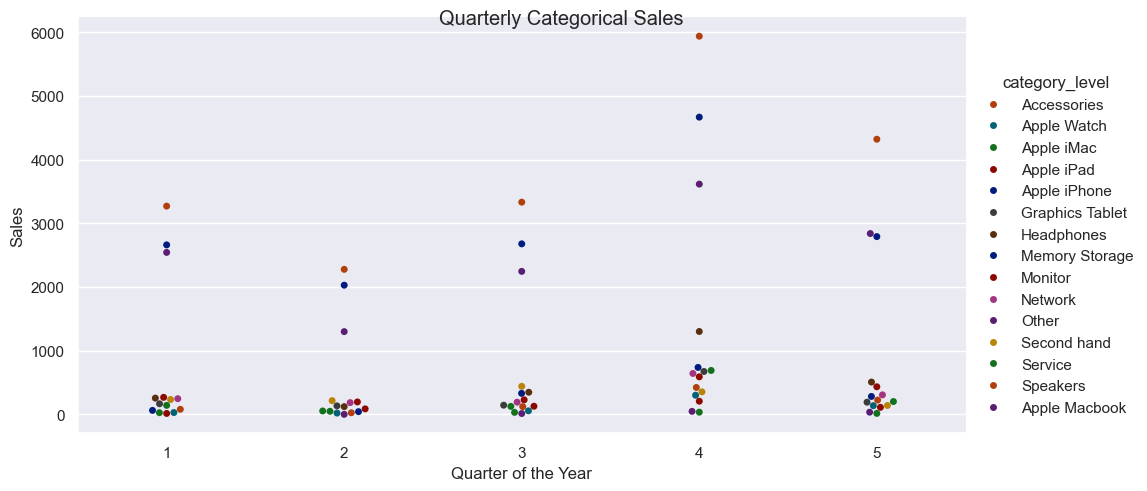

In [26]:
(sns.catplot(
    data=rev_sale_cat_qt, x="year_quarter", y="product_quantity", hue="category_level",
    kind="swarm", palette= color_mapping,aspect=2
).set_axis_labels("Quarter of the Year",
                  "Sales")
    .figure.suptitle("Quarterly Categorical Sales"))

Text(0.5, 0.98, 'Categorical reveneu Vs sales')

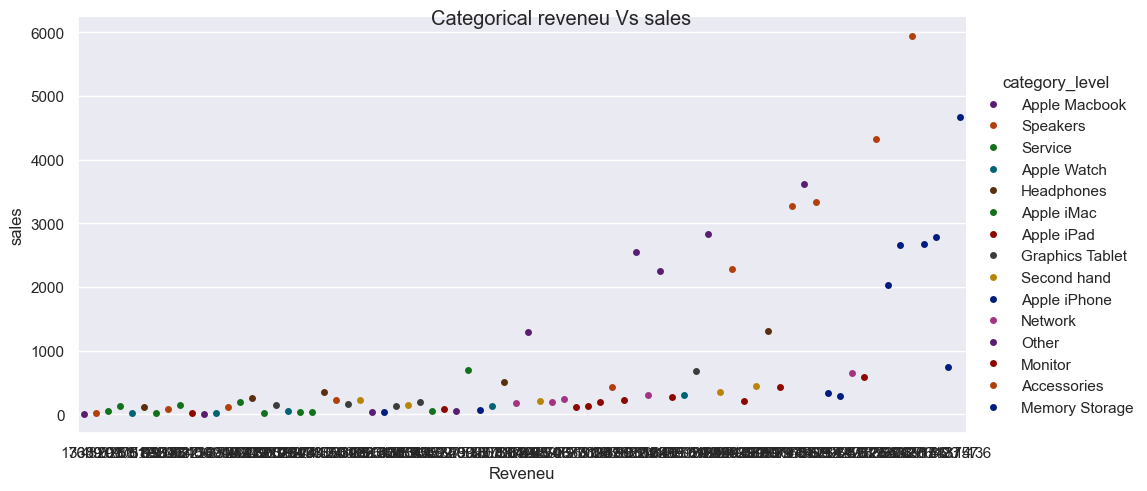

In [27]:
(
sns.catplot(data = rev_sale_cat_qt,
                 hue ="category_level",
                 x="unit_price_total",
                 y="product_quantity",
                 kind="swarm",
                 aspect = 2,
                 palette = color_mapping)
                .set_axis_labels("Reveneu",
                                 "sales" )
    .figure.suptitle("Categorical reveneu Vs sales")
)

In [28]:
list_open = ['open','second hand', 'like new', 'refubrished']
name_mask = orders_info['name'].str.lower().str.split().isin(list_open)
name_mask.sample(10)

48008    False
16610    False
48927    False
7152     False
27329    False
1405     False
9722     False
24807    False
50232    False
35812    False
Name: name, dtype: bool

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


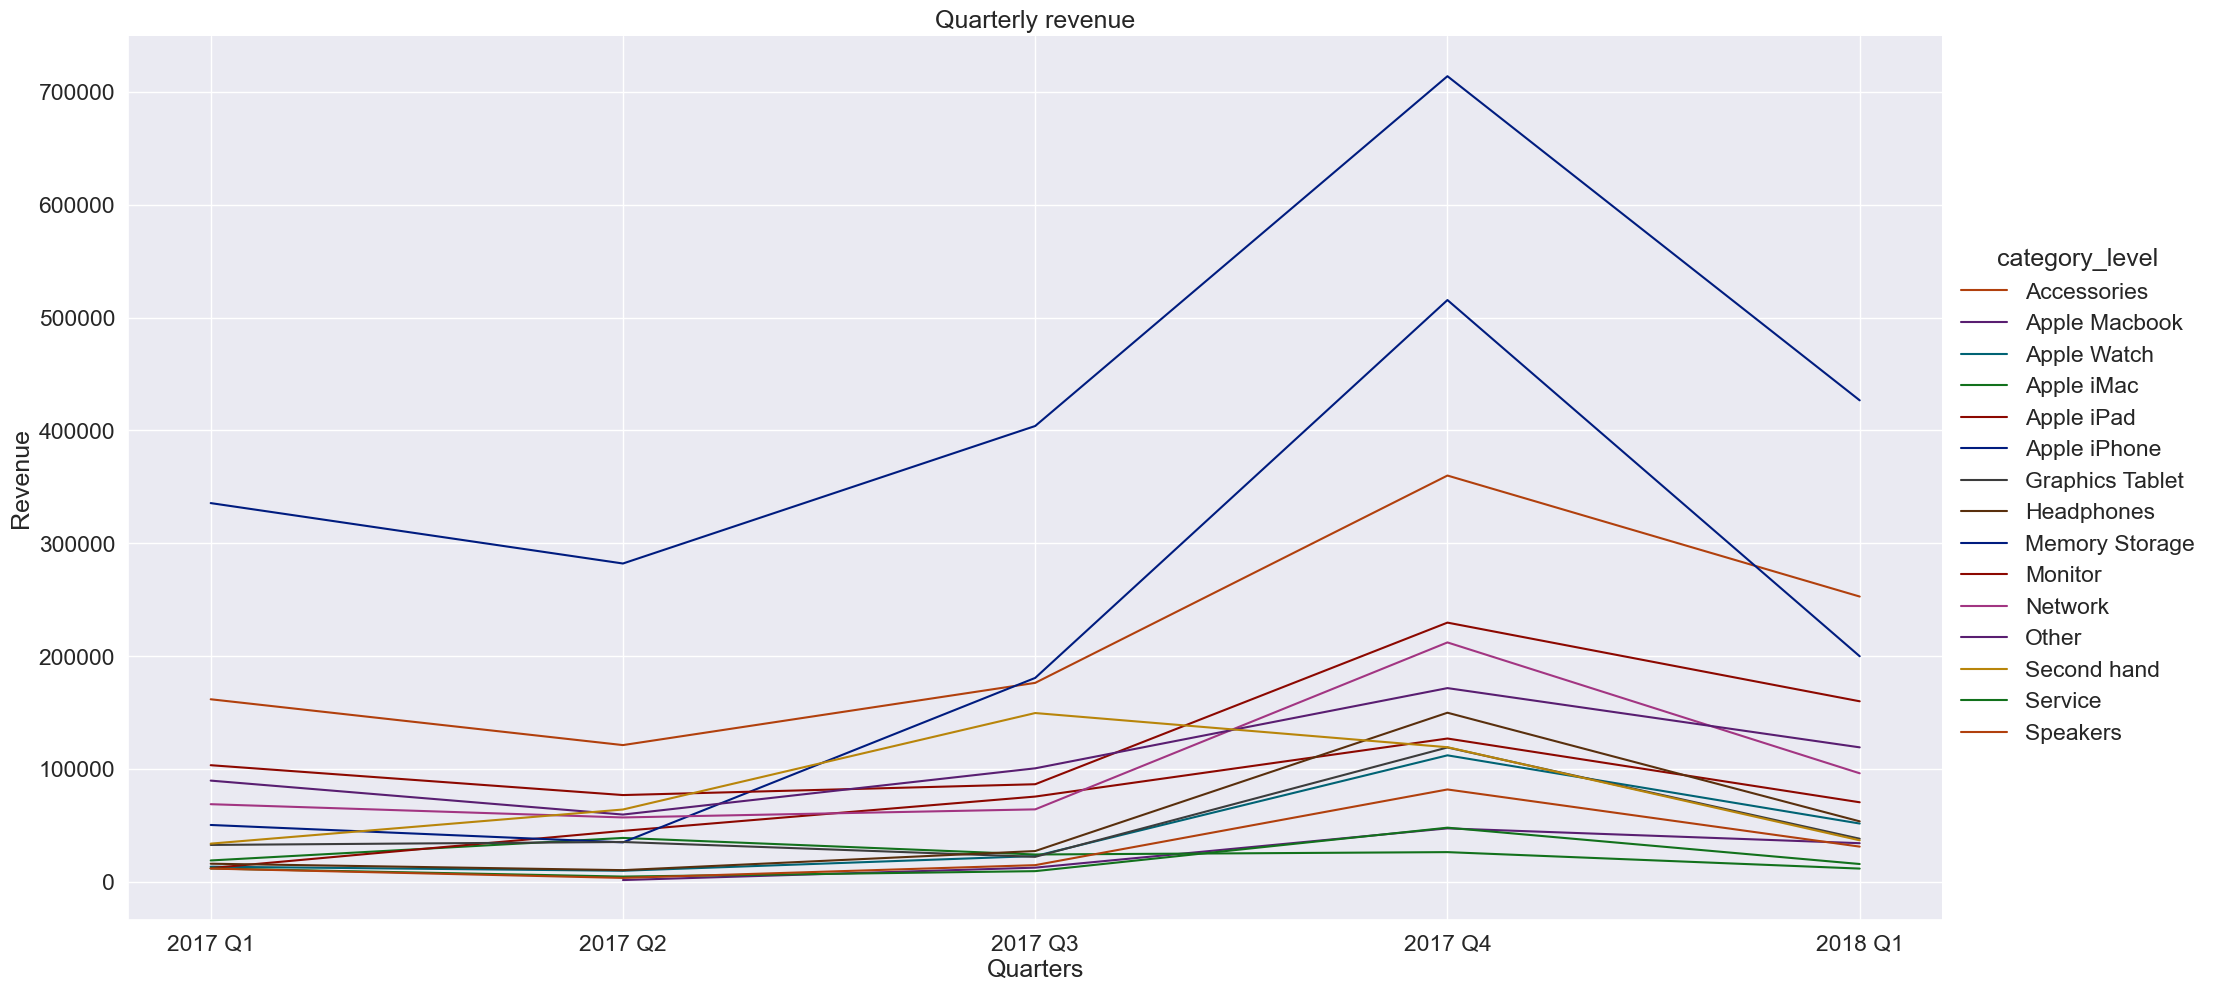

In [29]:
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("tab20")
ax = (
sns.relplot(data = rev_sale_cat_qt,
            x="year_quarter",
            y='unit_price_total',
            hue="category_level",
            kind="line",
            height= 10,
            palette=color_mapping,
            aspect=2)
    .set_axis_labels("Quarters",
                     "Revenue")
    .set(title="Quarterly revenue")
    .set(xticklabels=["2017 Q1", "2017 Q2", "2017 Q3", "2017 Q4", "2018 Q1"])
);
plt.xticks([1, 2, 3, 4, 5]);

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


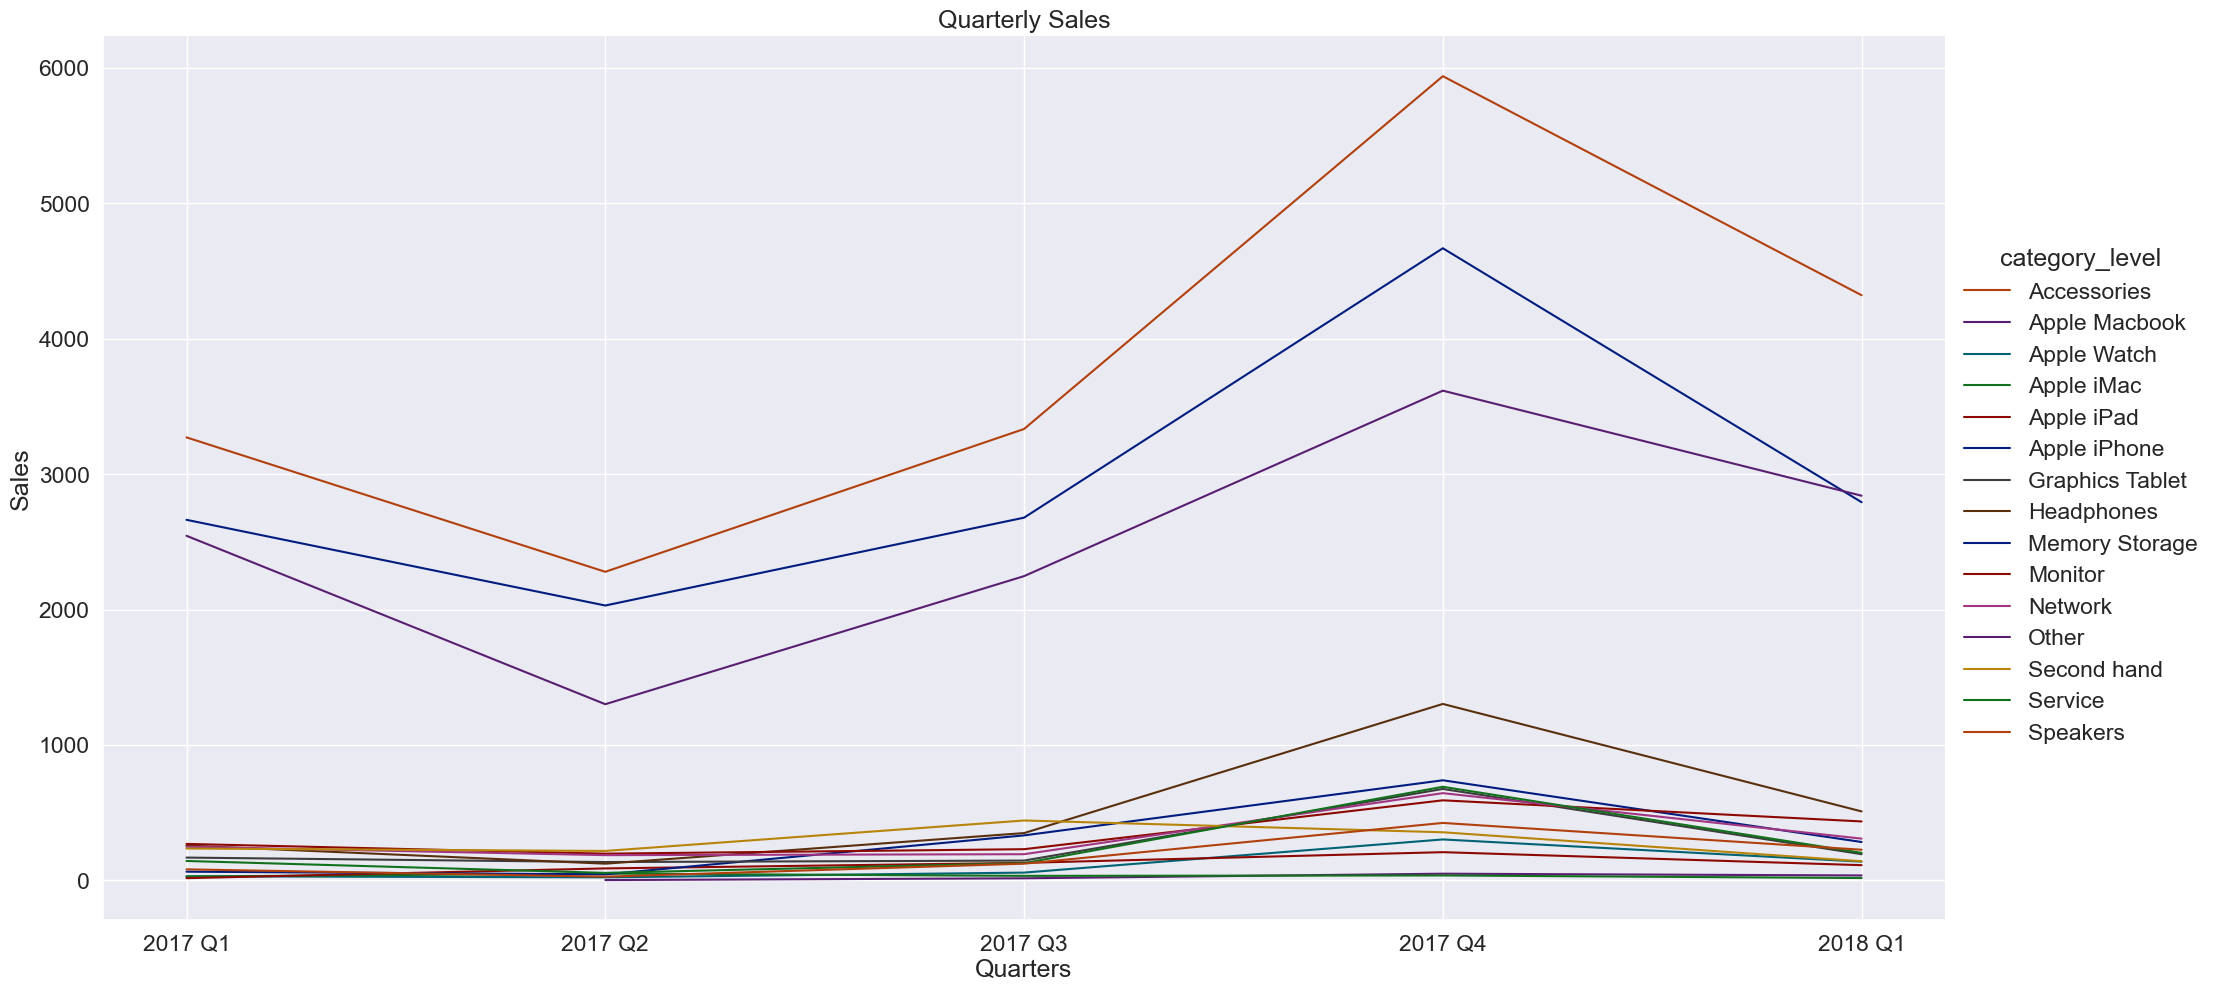

In [30]:
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("tab20")
ax = (
sns.relplot(data = rev_sale_cat_qt,
            x="year_quarter",
            y='product_quantity',
            hue="category_level",
            kind="line",
            height= 10,
            palette=color_mapping,
            aspect=2)
    .set_axis_labels("Quarters",
                     "Sales")
    .set(title="Quarterly Sales")
    .set(xticklabels=["2017 Q1", "2017 Q2", "2017 Q3", "2017 Q4", "2018 Q1"])
);
plt.xticks([1, 2, 3, 4, 5]);

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


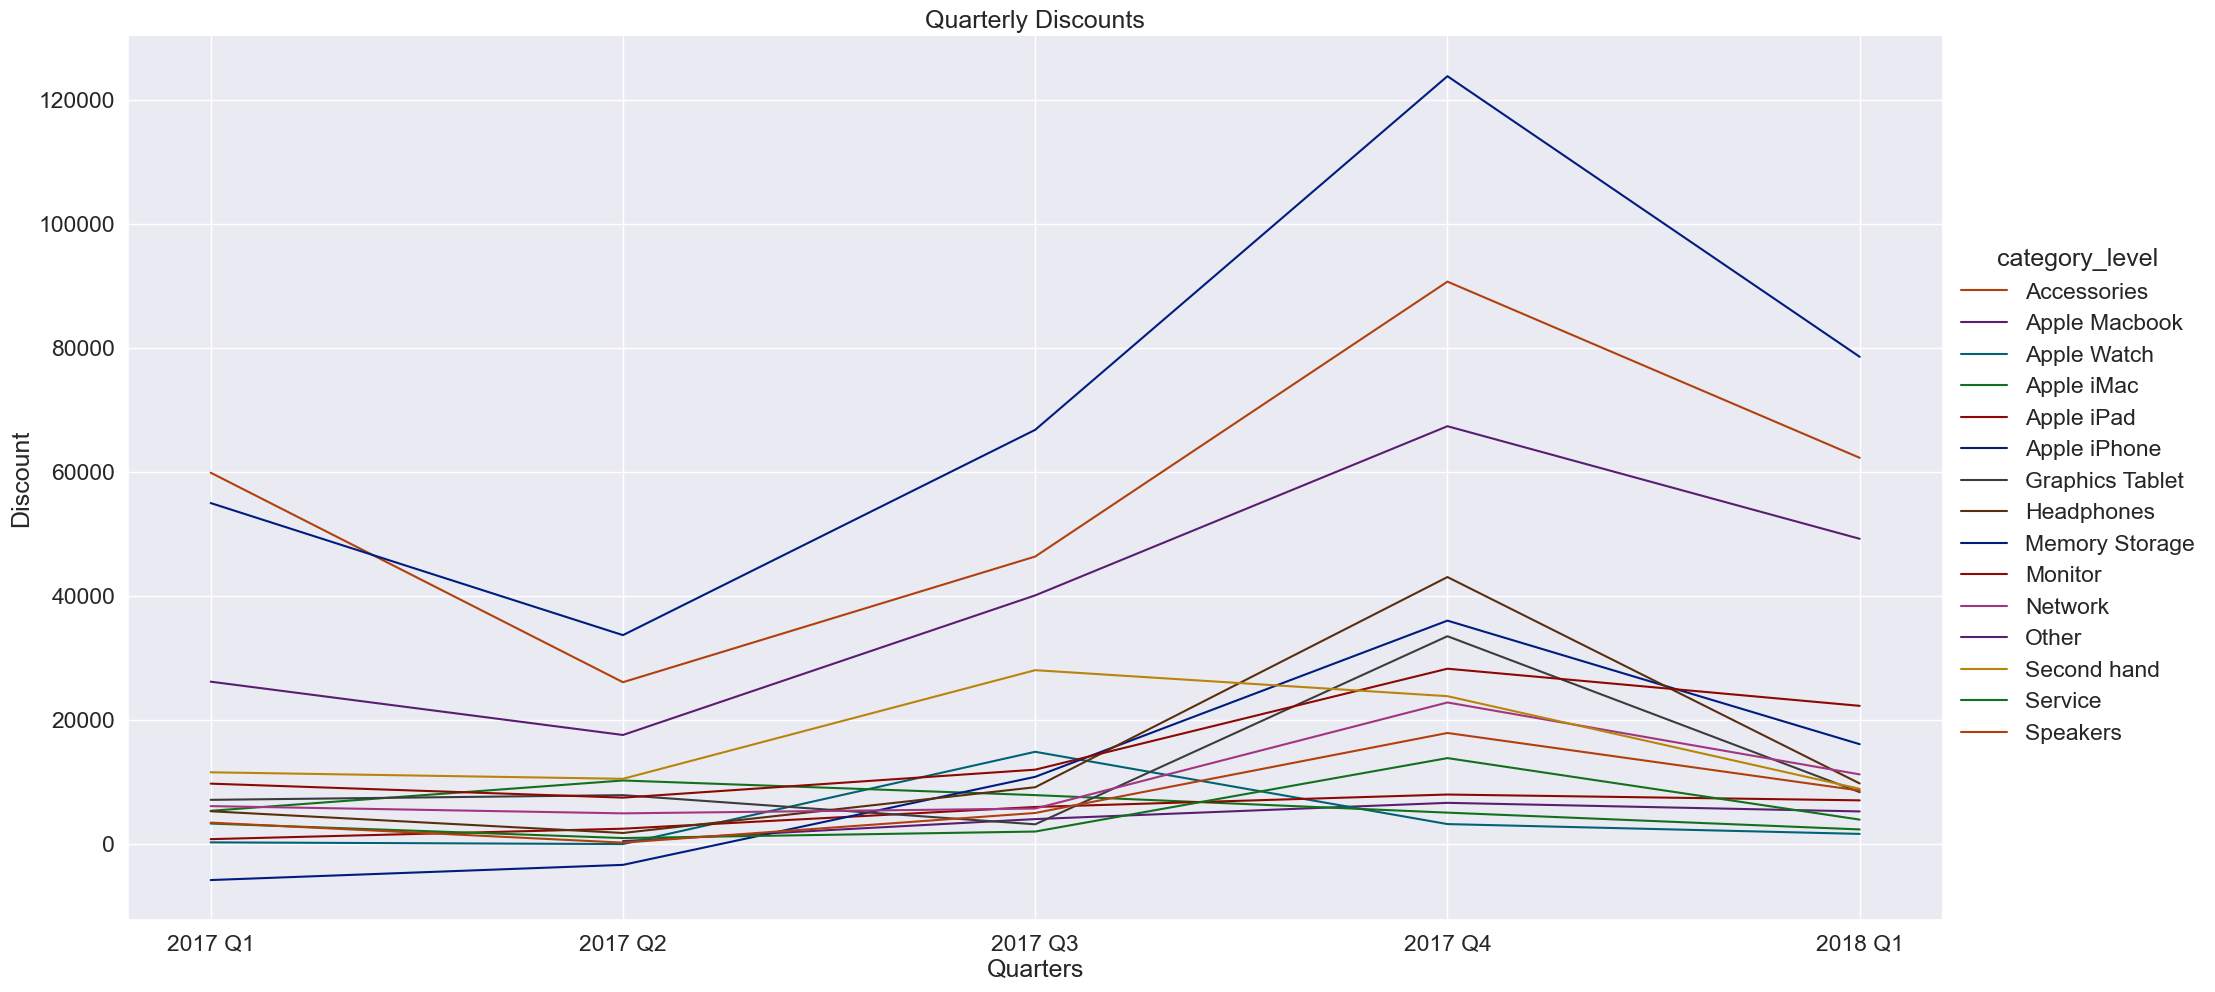

In [31]:
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("tab20")
ax = (
sns.relplot(data = rev_sale_cat_qt,
            x="year_quarter",
            y='discount',
            hue="category_level",
            kind="line",
            height= 10,
            palette=color_mapping,
            aspect=2)
    .set_axis_labels("Quarters",
                     "Discount")
    .set(title="Quarterly Discounts")
    .set(xticklabels=["2017 Q1", "2017 Q2", "2017 Q3", "2017 Q4", "2018 Q1"])
);
plt.xticks([1, 2, 3, 4, 5]);

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/relational.py:733: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


ValueError: Could not interpret value `total_paid` for `y`. An entry with this name does not appear in `data`.

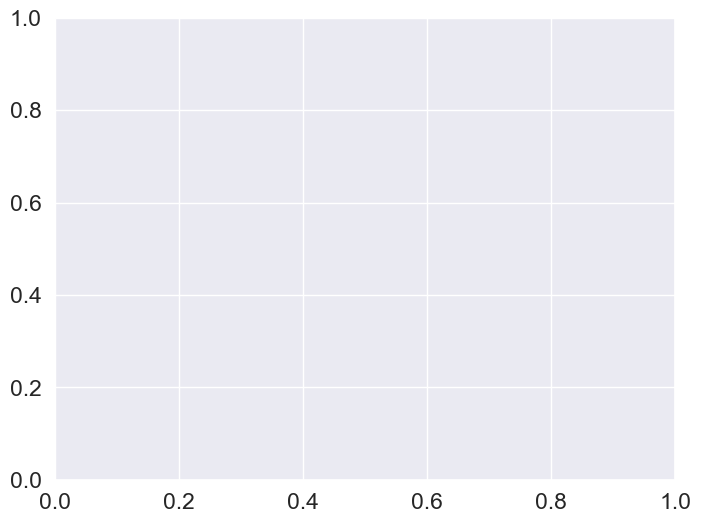

In [32]:
fig , ax1 = plt.subplots(figsize = (8,6))
(
sns.relplot(data = rev_sale_cat_qt,
            x="year_quarter",
            y='total_paid',
            hue="category_level",
            kind="line",
            height= 10,
            palette=color_mapping,
            ax = ax1,
            aspect=2)
            # .set_axis_labels("Quarters",
            #          "Revenue")
            # .set(title="Quarterly revenue for Apple products")
            # .set(xticklabels=["2017 Q1", "2017 Q2", "2017 Q3", "2017 Q4", "2018 Q1"])
);
ax1.set_ylabel("Revenue")
ax2 =ax1.twinx()
(sns.relplot(data = rev_sale_cat_qt,
            x="year_quarter",
            y='product_quantity',
            hue="category_level",
            kind="line",
            height= 10,
            palette=color_mapping,
            ax = ax1,
            aspect=2)
            # .set_axis_labels("Quarters",
            #          "Revenue")
            # .set(title="Quarterly revenue for Apple products")
            # .set(xticklabels=["2017 Q1", "2017 Q2", "2017 Q3", "2017 Q4", "2018 Q1"])
)

ax2.set_ylabel("Sales")
plt.xticks([1, 2, 3, 4, 5]);
plt.title("Reveneu and Sales for each Quarter")